# CS3244 Project: ResNet50 implementation to study leaf disease

Run the code below to make sure that your environtment is correctly set up before continuing running the main section below

In [1]:
import sys
import os
import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import seaborn as sn

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print(f"Seaborn {sn.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Init Plugin
Init Graph Optimizer
Init Kernel
Tensor Flow Version: 2.5.0
Keras Version: 2.5.0

Python 3.9.12 | packaged by conda-forge | (main, Mar 24 2022, 23:24:38) 
[Clang 12.0.1 ]
Pandas 1.4.2
Scikit-Learn 1.0.2
Seaborn 0.11.2
GPU is available


## Implementation set up

Import necessary library and methods

In [2]:
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

The data is taken from Kaggle open data set [New Plant Diseases Dataset](https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset).
The data has been filtered and for this project the focus is only on Corn, Potato and Tomato because they are staple food and vegetable. This is so it is inline with the mission of the project which is detecting of disease plants in vertical farm.

The parameters of the image data we use is as follow:
- Dimension: 256x256
- Colour space: RGB
- Alpha channel: no

So there are a total of 3 channels for the image (corresponding to Red, Green, Blue)

The *_dir variable refer to the directory where the train data is at and where the test data is at.

The validation data from the dataset is being used as a test set because the original test data is not sufficient. We split the training set into a training set and a validation set using Keras API as shown in the code later on.

In [3]:
IMG_HEIGHT, IMG_WIDTH = (256, 256)
BATCH_SIZE = 64

train_data_dir = r"archive/data/train"
test_data_dir = r"archive/data/test"

train_corn_dir = os.path.join(train_data_dir, 'corn')
train_potato_dir = os.path.join(train_data_dir, 'potato')
train_tomato_dir = os.path.join(train_data_dir, 'tomato')

test_corn_dir = os.path.join(test_data_dir, 'corn')
test_potato_dir = os.path.join(test_data_dir, 'potato')
test_tomato_dir = os.path.join(test_data_dir, 'tomato')

To get a rough number of how many images are in each file we create a small get_number function.

In [4]:
def get_number(directory):
  count = 0

  for folder in os.listdir(directory):
    if folder.startswith('.'):
      continue
    tmp = os.path.join(directory, folder)
    count += len(os.listdir(tmp))

  return count

print(f"{len(os.listdir(train_corn_dir))-1} classes with {get_number(train_corn_dir)} images in training corn folder")
print(f"{len(os.listdir(train_potato_dir))-1} classes with {get_number(train_potato_dir)} images in training potato folder")
print(f"{len(os.listdir(train_tomato_dir))-1} classes with {get_number(train_tomato_dir)} images in training tomato folder")
print('\n')
print(f"{len(os.listdir(test_corn_dir))-1} classes with {get_number(test_corn_dir)} images in testing corn folder")
print(f"{len(os.listdir(test_potato_dir))-1} classes with {get_number(test_potato_dir)} images in testing potato folder")
print(f"{len(os.listdir(test_tomato_dir))-1} classes with {get_number(test_tomato_dir)} images in testing tomato folder")


4 classes with 7316 images in training corn folder
3 classes with 5702 images in training potato folder
10 classes with 18345 images in training tomato folder


4 classes with 1829 images in testing corn folder
3 classes with 1426 images in testing potato folder
10 classes with 4586 images in testing tomato folder


From the number we can see that the dataset has sufficient images. To save on both runtime and computational power, we choose an EPOCHS of 20 which will yield roughly 100 images per batch (or a batch size of 100).

In [5]:
EPOCHS = 10

Here we use Keras API to clean and regenerate the dataset for us so that we can use them for training and testing.

In [6]:
train_datagen = ImageDataGenerator(
  preprocessing_function=preprocess_input,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
  validation_split=0.2, #reserving 20% of the data for validation 
)

def create_generator(ls):
  train = train_datagen.flow_from_directory(
      directory=ls,
      target_size=(IMG_HEIGHT, IMG_WIDTH),
      batch_size=BATCH_SIZE,
      seed=17, #for reproducibility
      class_mode='categorical',
      subset='training'
      )

  valid = train_datagen.flow_from_directory(
    directory=ls,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    seed=17, #for reproducibility
    class_mode='categorical',
    subset='validation'
    )
  
  return train, valid

train_corn_generator, valid_corn_generator = create_generator(train_corn_dir)
train_potato_generator, valid_potato_generator = create_generator(train_potato_dir)
train_tomato_generator, valid_tomato_generator = create_generator(train_tomato_dir)


Found 5855 images belonging to 4 classes.
Found 1461 images belonging to 4 classes.
Found 4564 images belonging to 3 classes.
Found 1138 images belonging to 3 classes.
Found 14678 images belonging to 10 classes.
Found 3667 images belonging to 10 classes.


In [26]:
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
    )

def create_test(ls):
  return test_datagen.flow_from_directory(
      directory=ls,
      target_size=(IMG_HEIGHT, IMG_WIDTH),
      batch_size=1,
      class_mode="categorical"
      )
test_corn_generator = create_test(test_corn_dir)
test_potato_generator = create_test(test_potato_dir)
test_tomato_generator = create_test(test_tomato_dir)

Found 1829 images belonging to 4 classes.
Found 1426 images belonging to 3 classes.
Found 4585 images belonging to 10 classes.


In [14]:
def generate_ResNet50_model(train_generator, valid_generator, title):
  base_model = ResNet50(include_top=False, weights = "imagenet")
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(1024, activation='relu')(x)

  predictions = Dense(train_generator.num_classes, activation="softmax")(x)
  model = Model(inputs=base_model.input, outputs=predictions)

  for layer in base_model.layers: #prevent retraining of weight
    layer.trainable = False

  model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
    )
  model.summary()

  history = model.fit(
    train_generator, 
    validation_data=valid_generator, 
    epochs=EPOCHS,
    verbose=1
    )
  model.save(title)

  return history

In [21]:
def generate_accuracy_graph(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.axis(ymin=0.9,ymax=1)
  plt.grid()
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epochs')
  plt.xticks([i for i in range(EPOCHS + 1)], [i for i in range(1,EPOCHS + 2)])
  plt.legend(['train', 'validation'])
  plt.show()

## Model for corn

In [16]:
corn_history = generate_ResNet50_model(
  train_corn_generator, 
  valid_corn_generator,
  "corn_model.h5"
  )

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

2022-04-13 17:25:44.882288: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-13 17:25:44.883586: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/10


2022-04-13 17:25:45.970800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


92/92 [==============================] - ETA: 0s - loss: 0.2108 - accuracy: 0.9375

2022-04-13 17:26:32.017898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


92/92 [==============================] - 59s 613ms/step - loss: 0.2108 - accuracy: 0.9375 - val_loss: 0.0882 - val_accuracy: 0.9665
Epoch 2/10
92/92 [==============================] - 58s 625ms/step - loss: 0.0946 - accuracy: 0.9674 - val_loss: 0.1026 - val_accuracy: 0.9658
Epoch 3/10
92/92 [==============================] - 57s 613ms/step - loss: 0.0535 - accuracy: 0.9792 - val_loss: 0.0864 - val_accuracy: 0.9658
Epoch 4/10
92/92 [==============================] - 57s 604ms/step - loss: 0.0456 - accuracy: 0.9824 - val_loss: 0.0566 - val_accuracy: 0.9795
Epoch 5/10
92/92 [==============================] - 56s 603ms/step - loss: 0.0376 - accuracy: 0.9857 - val_loss: 0.0593 - val_accuracy: 0.9754
Epoch 6/10
92/92 [==============================] - 58s 618ms/step - loss: 0.0404 - accuracy: 0.9855 - val_loss: 0.0658 - val_accuracy: 0.9788
Epoch 7/10
92/92 [==============================] - 57s 605ms/step - loss: 0.0350 - accuracy: 0.9880 - val_loss: 0.0640 - val_accuracy: 0.9719
Epoch 8/10

/Users/yuuki/.pyenv/versions/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


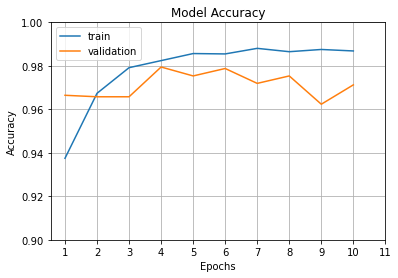

In [22]:
generate_accuracy_graph(corn_history)

In [28]:
saved_model = load_model('corn_model.h5')
test_loss, test_acc = saved_model.evaluate(test_corn_generator, verbose=2)
print(f"\nTest accuracy: {test_acc}")

2022-04-13 18:28:04.900626: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1829/1829 - 39s - loss: 0.0512 - accuracy: 0.9792

Test accuracy: 0.9792236685752869


## Model for potato

In [30]:
potato_history = generate_ResNet50_model(
  train_potato_generator, 
  valid_potato_generator,
  "potato_model.h5"
  )

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

2022-04-13 18:32:23.800773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


72/72 [==============================] - ETA: 0s - loss: 0.5123 - accuracy: 0.8753

2022-04-13 18:33:02.642954: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


72/72 [==============================] - 49s 656ms/step - loss: 0.5123 - accuracy: 0.8753 - val_loss: 0.0585 - val_accuracy: 0.9807
Epoch 2/10
72/72 [==============================] - 47s 646ms/step - loss: 0.0325 - accuracy: 0.9897 - val_loss: 0.0391 - val_accuracy: 0.9912
Epoch 3/10
72/72 [==============================] - 47s 630ms/step - loss: 0.0171 - accuracy: 0.9947 - val_loss: 0.0318 - val_accuracy: 0.9868
Epoch 4/10
72/72 [==============================] - 47s 640ms/step - loss: 0.0206 - accuracy: 0.9928 - val_loss: 0.0152 - val_accuracy: 0.9930
Epoch 5/10
72/72 [==============================] - 48s 655ms/step - loss: 0.0100 - accuracy: 0.9974 - val_loss: 0.0122 - val_accuracy: 0.9947
Epoch 6/10
72/72 [==============================] - 51s 690ms/step - loss: 0.0067 - accuracy: 0.9987 - val_loss: 0.0169 - val_accuracy: 0.9938
Epoch 7/10
72/72 [==============================] - 50s 672ms/step - loss: 0.0047 - accuracy: 0.9991 - val_loss: 0.0187 - val_accuracy: 0.9947
Epoch 8/10

/Users/yuuki/.pyenv/versions/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


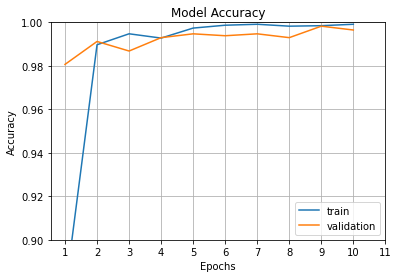

In [31]:
generate_accuracy_graph(potato_history)

In [32]:
saved_model = load_model('potato_model.h5')
test_loss, test_acc = saved_model.evaluate(test_potato_generator, verbose=2)
print(f"\nTest accuracy: {test_acc}")

2022-04-13 18:40:37.651294: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1426/1426 - 32s - loss: 0.0047 - accuracy: 0.9986

Test accuracy: 0.9985974431037903


## Model for tomato

In [33]:
tomato_history = generate_ResNet50_model(
  train_tomato_generator, 
  valid_tomato_generator,
  "tomato_model.h5"
  )

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

2022-04-13 18:41:11.840838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


230/230 [==============================] - ETA: 0s - loss: 0.4180 - accuracy: 0.8704

2022-04-13 18:43:09.326148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


230/230 [==============================] - 149s 634ms/step - loss: 0.4180 - accuracy: 0.8704 - val_loss: 0.4991 - val_accuracy: 0.8315
Epoch 2/10
230/230 [==============================] - 136s 585ms/step - loss: 0.1625 - accuracy: 0.9442 - val_loss: 0.1637 - val_accuracy: 0.9386
Epoch 3/10
230/230 [==============================] - 136s 590ms/step - loss: 0.0983 - accuracy: 0.9671 - val_loss: 0.1240 - val_accuracy: 0.9550
Epoch 4/10
230/230 [==============================] - 135s 584ms/step - loss: 0.0938 - accuracy: 0.9688 - val_loss: 0.1345 - val_accuracy: 0.9542
Epoch 5/10
230/230 [==============================] - 133s 577ms/step - loss: 0.0779 - accuracy: 0.9724 - val_loss: 0.1959 - val_accuracy: 0.9384
Epoch 6/10
230/230 [==============================] - 135s 584ms/step - loss: 0.0742 - accuracy: 0.9728 - val_loss: 0.2134 - val_accuracy: 0.9346
Epoch 7/10
230/230 [==============================] - 134s 579ms/step - loss: 0.0662 - accuracy: 0.9756 - val_loss: 0.1198 - val_accura

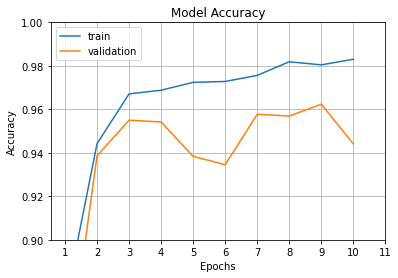

In [34]:
generate_accuracy_graph(tomato_history)

In [35]:
saved_model = load_model('tomato_model.h5')
test_loss, test_acc = saved_model.evaluate(test_tomato_generator, verbose=2)
print(f"\nTest accuracy: {test_acc}")

2022-04-13 19:03:55.009864: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4585/4585 - 100s - loss: 0.2075 - accuracy: 0.9381

Test accuracy: 0.9380588531494141


## Graph representation of the result

In [41]:
corn_model10 = load_model("model10/corn_model.h5")
potato_model10 = load_model("model10/potato_model.h5")
tomato_model10 = load_model("model10/tomato_model.h5")

corn_model20 = load_model("model20/corn_model.h5")
potato_model20 = load_model("model20/potato_model.h5")
tomato_model20 = load_model("model20/tomato_model.h5")

In [37]:
def generate_graph(model, test_generator):
  # filenames = test_generator.filenames
  nb_samples = len(test_generator)
  y_prob=[]
  y_act=[]
  test_generator.reset()

  for _ in range(nb_samples):
    x,y = test_generator.next()
    y_act.append(y)
    y_prob.append(model.predict(x))

  predicted_class = [list(test_generator.class_indices.keys())[i.argmax()] for i in y_prob]
  actual_class = [list(test_generator.class_indices.keys())[i.argmax()] for i in y_act]

  out_df = pd.DataFrame(
    np.vstack([predicted_class, actual_class]).T, 
    columns=['Predicted', 'Actual']
    )

  confusion_matrix = pd.crosstab(
    out_df['Actual'], 
    out_df['Predicted'], 
    rownames=['Actual'], 
    colnames=['Predicted']
    )

  sn.heatmap(
    confusion_matrix, 
    cmap='Blues', 
    annot=True, fmt='d'
  )

  plt.show()

  print("Test accuracy: {}".format((np.diagonal(confusion_matrix).sum() / confusion_matrix.sum().sum()*100)))

### Corn graph

10 epochs result

2022-04-13 19:05:37.847021: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


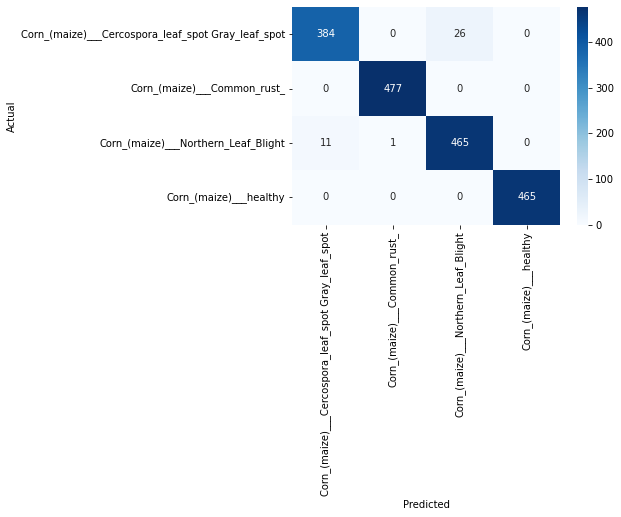

Test accuracy: 97.92236194641882


In [38]:
generate_graph(corn_model10, test_corn_generator)

20 epochs result

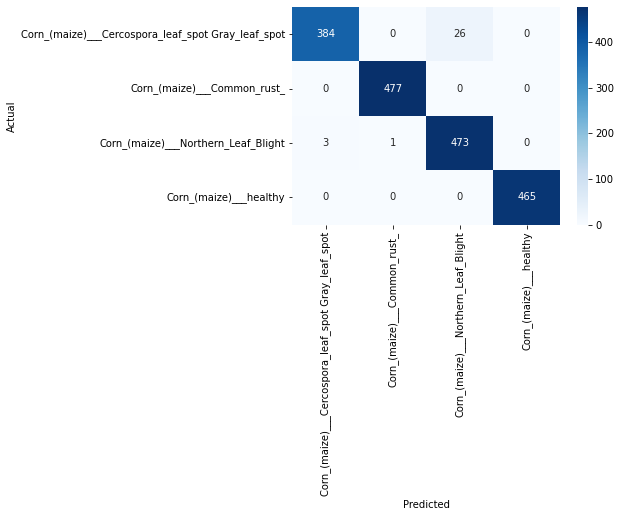

Test accuracy: 98.35975943138327


In [44]:
generate_graph(corn_model20, test_corn_generator)

### Potato graph

10 epochs results

2022-04-13 19:06:36.648390: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


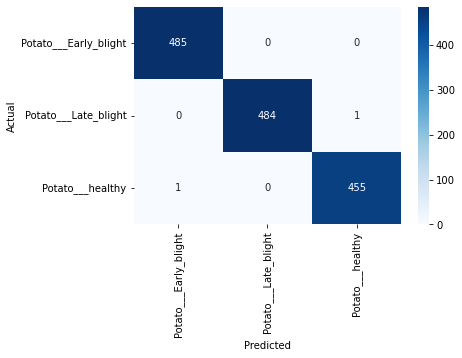

Test accuracy: 99.85974754558204


In [39]:
generate_graph(potato_model10, test_potato_generator)

20 epochs result

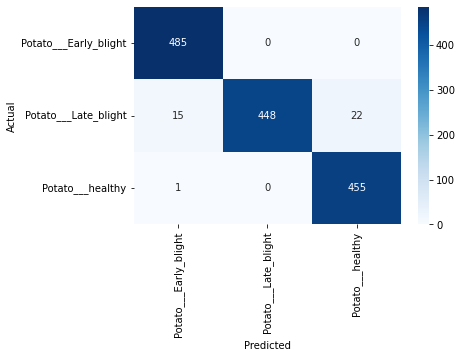

Test accuracy: 97.3352033660589


In [46]:
generate_graph(potato_model20, test_potato_generator)

### Tomato graph

10 epochs result

2022-04-13 19:07:23.529094: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


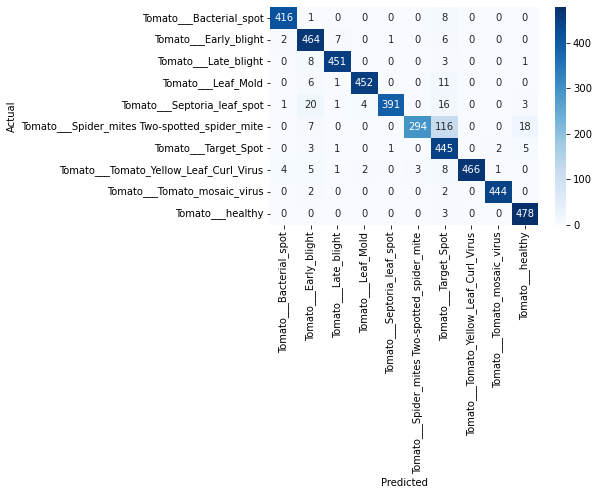

Test accuracy: 93.80588876772083


In [40]:
generate_graph(tomato_model10, test_tomato_generator)

20 epochs result

2022-04-13 19:20:31.606501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


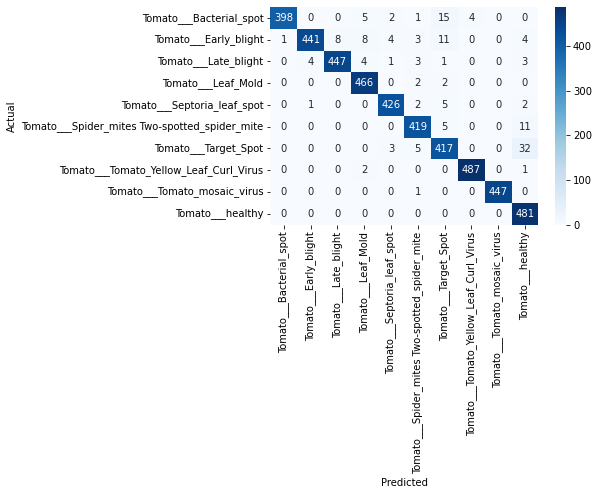

Test accuracy: 96.59760087241003


In [47]:
generate_graph(tomato_model20, test_tomato_generator)